## Problem: Crater Detection
Developing a reliable crater detection algorithm (CDA) is an important and ongoing project in Astronomy.<br>
Crater statistics (count and size distributions) are important for planetary geology, specifically determining the age of a planetary surface. Due to a wealth of high-resolution imaging on Mars, there has been an extensive effort to catalogue all of the visible craters on the red planet. Craters in greater than 1 km in diameter on Mars have been identified and documented exhaustively in one heroic effort by a researcher named <a href='https://astrogeology.usgs.gov/search/details/Mars/Research/Craters/RobbinsCraterDatabase_20120821/zip'>Stuart Robbins</a>. Once you start looking at craters smaller than 1 km in diameter, the task of hand-labeling every crater explodes; there are exponentially more craters as you lower the minimum crater diameter for your catalog. The need for a reliable CDA becomes glaringly obvious.<br>
Among the most important work on this problem in the previous decade is documented in numerous papers:<br><a href='https://www.lpi.usra.edu/meetings/lpsc2010/pdf/1144.pdf'><I>Automatic Detection of Sub-km Craters using Shape and Texture Information</I></a> (2010 Bandiera et al.), which uses a two-step process to address the problem. The basic steps are:
 1. Identify "crater candidates" using shape filters in a process developed <a href='https://www.sciencedirect.com/science/article/pii/S0032063309000956'>in this paper</a> by Urback et al. in 2009.
 2. Classify candidates as craters or non-craters using Haar-like image texture features and an AdaBoost classifier.
<br>


This research shows promising results, improving on previous algorithm performance. Importantly, the method opens the problem up to more researchers as a simple classification problem. Further progress on this binary classification problem is achieved in <a href='https://arxiv.org/pdf/1601.00978.pdf'><I>Crater Detection via Convolutional Neural Networks</I></a> (2016 Cohen et al.) This group is able to improve on the binary classification problem with an F1 score close to 90% on each of the three benchmark terrains on Mars.

CNNs have also been employed experimentally with better results than Urbach in 2009 at identifying crater candidates; preliminary research on this approach will be presented in March at the <a href='https://www.hou.usra.edu/meetings/lpsc2018/'>49th Lunar and Planetary Science Conference</a> in March (<a href='https://www.hou.usra.edu/meetings/lpsc2018/pdf/1948.pdf'>this is the abstract for that presentation</a>).

## Lack of Deployable Product

With so much promising research on this topic, there is a disappointing lack of usable software. To actually apply these techniques, a researcher needs reproduce the methods used in the papers. This is probably due to a lack of funding in planetary geology, as NASA's budget it spread between many fields.

## Project Proposal: "Crater2Vec"
My Capstone project proposal consists of recreating the works described above and deploying them in a user-friendly python package. The target user experience is this:
 1. Import the package and crater detection models
 2. Call .predict() method on an image (arbitrary size)
 3. Get nx3 tensor as output, where:
     - n is the number of craters detected
     - x is the horizontal position of a crater (pixels)
     - y is the vertical position of a crater (pixels)
     - d is the diameter of the crater (pixels)<br>
     
This is a simple user experience with some tricky steps in between. However, all of the difficult problems have been addressed by the various papers above. My project is to put all of these experimental results together and build Crater2Vec.

## Project Outline: Dataset
A great starting point for this project is the Martian surface tiles used in Urbach, Bandeira, and Cohen (uploaded to GitHub by Cohen; many thanks to him for that!)

The Data:
Six 1700x1700 pixel greyscale images of Martian Surface, in the Nanedi Valles region.

In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
import string
from sklearn import metrics
import test_human
import matplotlib.patches as mpatches
%matplotlib inline

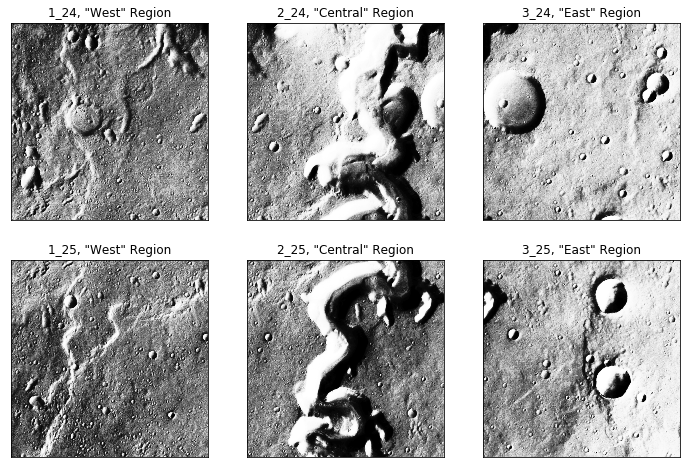

In [2]:
tile_names = [
    'tile1_24',
    'tile2_24',
    'tile3_24',
    'tile1_25',
    'tile2_25',
    'tile3_25',
]
regions = [
    '"West" Region',
    '"Central" Region',
    '"East" Region',
    '"West" Region',
    '"Central" Region',
    '"East" Region',
]

tiles = {}
for name in tile_names:
    num = name[4:]
    tiles[num] = PIL.Image.open(name + 's.pgm')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
axes = axes.reshape(6,)
for i, ax in enumerate(axes):
    ax.tick_params(
        axis='both', 
        which='both', 
        bottom='off', 
        top='off', 
        labelbottom='off', 
        right='off', 
        left='off', 
        labelleft='off'  # labels along the bottom edge are off
        )
    tile = tile_names[i][4:]
    ax.set_title(tile + ', ' + regions[i])
    img = tiles[tile]
    ax.imshow(np.array(img), cmap='Greys')

Each tile is 1700x1700 pixels, and each pixel is 12.5 square meters of the Martian surface. There is some overlap between the tiles, but each tile covers about 450 square kilometers; the entire photographed region spans ~37 km N-S and ~56 km E-W.

## "Ground Truth" Labels
Along with the dataset comes a set of 3658 crater annotations hand-labeled by an analyst for Urbach in his 2009 paper. In all subsequent papers using this dataset, these annotations are considered ground truths; that is, they are all the true craters that a human can identify in this area.

In [3]:
all_craters = pd.DataFrame(columns = ['x', 'y', 'd', 'tile'])
for tile in tile_names:
    num = tile[4:]
    new_craters = pd.read_csv('./gt_labels/{}_gt.csv'.format(num), header=None)
    new_craters.index = range(len(all_craters), len(all_craters)+len(new_craters))
    new_craters.columns = ['x', 'y', 'd']
    new_craters['tile'] = num
    all_craters = pd.concat([all_craters, new_craters], axis=0)
print('{} total number of labeled craters'.format(len(all_craters)))

3658 total number of labeled craters


In [4]:
demo_tile = '1_24'
img = tiles[demo_tile]

In [5]:
scale = .5

In [6]:
def plot_craters(tile, craters, title=None, scale=scale, colors=['r', 'y', 'cyan', 'o', 'g']):
    """Takes an input PIL image "tile" and a dictionary,
    with each key as a type of crater and its element a list
    of craters with form: (x, y, d) (xpos, ypos, diameter)
    """
    img = tile
    if not title:
        title = list(craters.keys())[0]
    size = (int(img.size[0]*scale/80), int(img.size[1]*scale/80))
    fig, ax = plt.subplots(figsize=size);
    ax.imshow(np.array(img), cmap='Greys');
    ax.set_title(title);
    ax.set_ylabel('N-S direction in pixels @12.5 meters/pixel')
    ax.set_xlabel('E-W direction in pixels @12.5 meters/pixel')
    handles = []
    for i, group in enumerate(craters):
        color = colors[i]
        handles.append(mpatches.Patch(color=color, label=group))
        for crater in craters[group]:
            x = crater[0]
            y = crater[1]
            r = crater[2]/2
            circle = plt.Circle((x, y), r, fill=False, color=color);
            ax.add_artist(circle);
    plt.legend(handles=handles);
    plt.show();
    return None

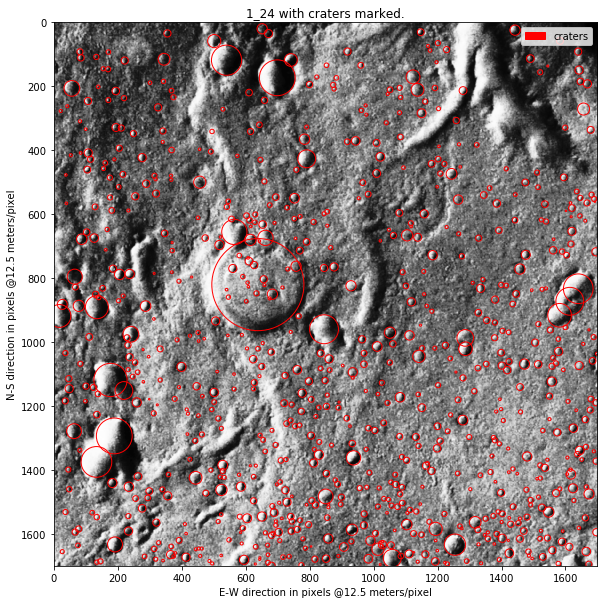

In [7]:
craters = all_craters[all_craters.tile=='1_24']
craters = {'craters': craters[['x', 'y', 'd']].values}
plot_craters(img, craters, title='{} with craters marked.'.format('1_24'))

## Crater proposals dataset
Urbach's method returns a set of "crater proposals" with many false positives included; the idea is to apply additional screening to accept or reject proposals. These proposals are limited to craters 200m (16 pixels) in diameter at minimum and 5km (400 pixels) in diameter at maximum; note many of the craters annotated above are smaller than that minimum threshold.

In [8]:
proposal_columns = all_craters.columns
true_proposals = pd.DataFrame(columns = proposal_columns)
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tp.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(true_proposals), len(true_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    true_proposals = pd.concat([true_proposals, new_proposals], axis=0)

In [9]:
false_proposals = pd.DataFrame(columns = proposal_columns)
for tile in tile_names:
    num = tile[4:]
    new_proposals = pd.read_csv('./bandiera2010_candidates/{}_tn.csv'.format(num), header=None)
    new_proposals.columns = ['x', 'y', 'd']
    new_proposals.index = range(len(false_proposals), len(false_proposals)+len(new_proposals))
    new_proposals['tile'] = num
    false_proposals = pd.concat([false_proposals, new_proposals], axis=0)

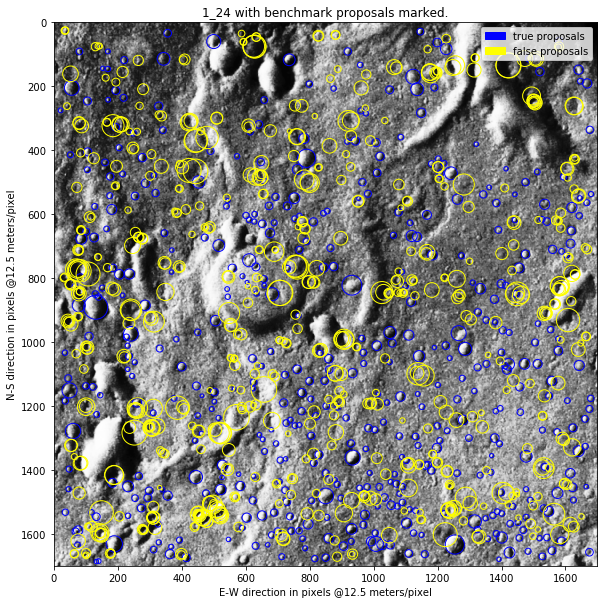

In [10]:
proposals = OrderedDict()
proposals['true proposals'] = true_proposals[true_proposals.tile=='1_24'][['x', 'y', 'd']].values
proposals['false proposals'] = false_proposals[false_proposals.tile=='1_24'][['x', 'y', 'd']].values
colors = ['blue', 'yellow']
title = '{} with benchmark proposals marked.'.format('1_24')
plot_craters(img, proposals, title=title, colors=colors)

## Proposal Classification
There has been great progress on classifying these proposals, most recently by use of neural nets. Some of Urbach's proposals include craters smaller than the reported minimum of 200m, with diameters of 10 pixels (125m). Without looking at the images, we can see some differences between the proposals.

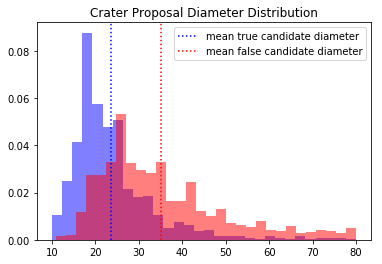

In [11]:
plt.hist(true_proposals.d.astype(int), bins=30, alpha=.5, normed=True, color='blue');
plt.axvline(x=true_proposals.d.mean(), color='blue', label='mean true candidate diameter', linestyle='dotted');
plt.hist(false_proposals.d.astype(int), bins=30, alpha=.5, normed=True, color='red');
plt.axvline(x=false_proposals.d.mean(), color='red', label='mean false candidate diameter', linestyle='dotted');
plt.title('Crater Proposal Diameter Distribution');
plt.xlabel('')
plt.legend();
plt.show();

## Cohen's Classifier
Cohen uses convolutional neural nets in 2016 to achieve an F-1 score close to .90 in a K=10 fold cross-validated attempt. His classifier uses cropped images of the proposed craters as an input and returns a binary output.<br>

In [12]:
def crop_crater(image, proposal):
    """Takes an input image of arbitrary size X, Y and a
    'crater', which is a tuplet (x, y, d) of a crater where
    x < X and y < Y. Returns a cropped image of dim 28x28 of
    the proposal.
    """
    x = proposal[0] #Record x and y positions
    y = proposal[1]
    r = max(14, proposal[2]) #"Radius" of image tbd
    #get four parameters of image box
    left = x - r
    upper = y - r
    right = x + r
    lower = y + r
    result = image.crop(box=(left, upper, right, lower))
    if result.size != (28, 28):
        result = result.resize((28, 28))
    return result

def invert_image(input_image):
    """inverts the input image color values. Returns image
    of same dim."""
    if not type(input_image) == type(np.array([0])):
        input_image = np.array(input_image)/256
    return (input_image - 256) * -1 

def normalize_image(input_image):
    """Takes a PIL image and "normalizes" its pixel values;
    returns a numpy array of same shape, with min value 0 and
    max value 256.
    """
    if not type(input_image) == type(np.array([0])):
        array = np.array(input_image)/256
    else:
        array = input_image
    min_ = np.min(np.min(array))
    array = array - min_
    max_ = np.max(np.max(array))
    array = array * 1/max_ * 256
    return array

In [13]:
# I tried to classify cropped images myself, the results of which are recorded in this human_performance.
human_performance = pd.read_csv('first_attempt.csv')
tp = np.where((human_performance.crater==1) & (human_performance.prediction==1), True, False)
fp = np.where((human_performance.crater==0) & (human_performance.prediction==1), True, False)
tn = np.where((human_performance.crater==0) & (human_performance.prediction==0), True, False)
fn = np.where((human_performance.crater==1) & (human_performance.prediction==0), True, False)

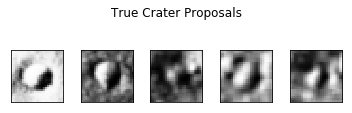

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2));
fig.suptitle('True Crater Proposals');
num = 0
for axis in ax:
    img = test_human.get_image(human_performance[tp]['id'].iloc[num])
    axis.imshow(img, cmap='Greys')
    axis = test_human.remove_ticks(axis)
    plt.tight_layout()
    num += 1

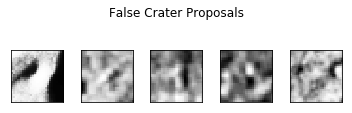

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2));
fig.suptitle('False Crater Proposals');
num = 0
for axis in ax:
    img = test_human.get_image(human_performance[tn]['id'].iloc[num])
    axis.imshow(img, cmap='Greys')
    axis = test_human.remove_ticks(axis)
    plt.tight_layout()
    num += 1

## It's not always easy
My mentor Matt pointed out that an important benchmark is human performance. I classified ~350 myself using <a href=''>this script</a> to see what a reasonable benchmark human performance would be. I didn't do too great, with an f1-score of .74. I'm not a field expert, but I am an astronomy graduate, which should count for something. In light of this, Cohen's ~.90 f-1 score is commendable. Here are some of the confusions I made:

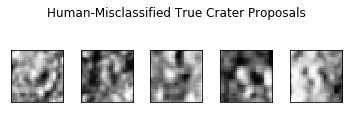

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2));
fig.suptitle('Human-Misclassified True Crater Proposals');
num = 0
for axis in ax:
    img = test_human.get_image(human_performance[fn]['id'].iloc[num])
    axis.imshow(img, cmap='Greys')
    axis = test_human.remove_ticks(axis)
    plt.tight_layout()
    num += 1

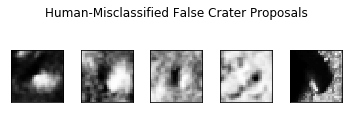

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2));
fig.suptitle('Human-Misclassified False Crater Proposals');
num = 0
for axis in ax:
    img = test_human.get_image(human_performance[fp]['id'].iloc[num])
    axis.imshow(img, cmap='Greys')
    axis = test_human.remove_ticks(axis)
    plt.tight_layout()
    num += 1

## Work to be Done
After extensive research, I have not found a usable extension of any of these projects. My project, then, will consist of building a pipeline to create the product earlier described (image in, nx3 tensor out) with the following structure:

    1. Input image yields a set of crater proposals via Urbach's method (which I will reproduce in Python code).
    2. Auxiliary code produces cropped images of each proposal.
    3. A binary classifier processes and labels each return a class probability.
    4. A user-provided sensitivity hyperparameter (default .5) will provide a classification threshold.
    5. The application returns the tensor of vetted crater proposals.
<br>
## An Extensible Framework for Crater Detection
The product of this work will not be perfect; experts in this field of research have not achieved perfect results, so I cannot expect to do so myself. However, I would like to build a framework and pipeline that astronomers can use and developers/researchers can extend and improve. This will allow researchers on future projects to use Crater2Vec to impliment their novel ideas, astronomers to conduct their own surveys of planetary surfaces, and any other amount of cool science/hacking.